## Implementation Steps

1. Consider 2009, 2010, 2011 data for train - These are the loans that have almost completed (except one quarter)
1. Column selection
	* Check each column population %
	* Check Variance and Mean of each column
	* Ignore columns with variance very low (ignore only 0)
	* Remove (judgement) if the field is not populated more than 50% and cannot be derived using other fields
	* Eliminate or Identify highly correlated data (is correlation > 0.85 valid?)
	* How else can we eliminate columns
		* Try PCA and see how many columns does PCA requires for a 99% accuracy
		* Because we dont have too many columns we can include PCA as a reference and not go serious on PCA
	* how else can we remove columns? - Manually?
1. Rows selection - Do not do this now. This can be done later
	* do we eliminate rows with more than 10% of "selected" columns?
1. Filling missing columns
	* Find out columns for which values are 
        * Missing completely at random - Impute these values using existing values
        * Missing at random - Impute these values using other columns within same data
        * Not missing at random - Hard to impute the values
    * Design suitable methods for filling missing values
1. Cleaning data
	* remove any extra charecters like ",", "$", "%" etc
	* make sure dataframe datatypes are as expected
1. Column Encoding
1. Column Standadization
1. Check PCA validity
1. Splitting train and validation data
	* loan staus of default or charged-off is flagged 1 else 0
1. Create Baseline Models: Run some basic models without hyper-parameter tuning
    * Random Model
    * Logistic Regression
    * LDA
    * QDA
    * Decision Trees
    * Random Forests
1. Models for Final submission:
    * Logistic Regression
    * Random Forests
    * SVM
    * Ada Boost
    * Gradient Boost
1. Tuning hyper-parameters for each model: Identify measures to tune each model
    * AUC of ROC Curve
1. Compare different models: Identify measures to validate across models (will use only few of below)
	* Precision - TP/(TP+FP)
    * Recall/Sensitivity - TP/(TP+FN)
	* Specificity - TN/(TN+FP)
	* Accuracy - (TN+TP)/N
	* F1 Score
    * Execution Cost (Time of Execution)
1. Visualizations: For each model
    * ROC Curve
    * Precision Recall Curve
    * Feature Importance
1. Future Work - May not be part of project
    * Feature Engineering
        * From existing features
            * Find new features within existing data
            * Check for interaction variables
            * Add text analysis on description fields
            * Explore url field to analyze more data
        * Creating external features
            * Employment Index
            * US census data
    * Prediction process
        * Prediction with multi-class loan-status

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import csv
from sklearn.preprocessing import Imputer
from IPython.display import display, HTML
from subprocess import check_call
import matplotlib.image as mpimg
import random
import time
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import datetime
import seaborn as sns
sns.set(color_codes=True)
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
# Reading full dataset. Please download dataset after creating login because it contains 4 important attributes (fico scores)
# Need to download file from web with name "LoanStats3a_securev1.csv.zip" and place under a subdirectory "datasets" under main script
full_data = pd.read_csv('datasets/LoanStats3a_securev1.csv', skiprows=1, delimiter = ',', quoting=csv.QUOTE_ALL)
# Out of dataset, please filter in data for 2009, 2010, 2011
full_data = full_data[full_data['issue_d'].str.contains("2011") |  full_data['issue_d'].str.contains("2010") | full_data['issue_d'].str.contains("2009")]
# Dropping URL and Description fields as they are of no interest right now
full_data.drop(['url', 'desc'], 1, inplace=True)
print 'Shape of full dataframe:', full_data.shape

#See how many columns have complete data
unq_count = pd.DataFrame([len(pd.unique(full_data[col].ravel())) for col in full_data.columns]).set_index(full_data.columns)
summary_df = pd.DataFrame(pd.concat([full_data.count(),  full_data.isnull().sum(), unq_count,  full_data.mean(), full_data.std()], axis = 1))
summary_df.columns = ['Count', 'NullCount', 'UniqueCount',  'Mean', 'Variance']
display(summary_df.sort(['UniqueCount', 'Variance'], ascending=[1, 1]))

Shape of full dataframe: (39539, 113)


Count  NullCount  UniqueCount           Mean  \
acc_now_delinq                  39539          0            1       0.000000   
chargeoff_within_12_mths        39539          0            1       0.000000   
collections_12_mths_ex_med      39539          0            1       0.000000   
delinq_amnt                     39539          0            1       0.000000   
policy_code                     39539          0            1       1.000000   
tax_liens                       39539          0            1       0.000000   
acc_open_past_24mths                0      39539            1            NaN   
all_util                            0      39539            1            NaN   
annual_inc_joint                    0      39539            1            NaN   
application_type                39539          0            1            NaN   
avg_cur_bal                         0      39539            1            NaN   
bc_open_to_buy                      0      39539            1            NaN   
bc_util                             0      39539            1            NaN   
dti_joint                           0      39539            1            NaN   
il_util                             0      39539            1            NaN   
initial_list_status             39539          0            1            NaN   
inq_fi                              0      39539            1            NaN   
inq_last_12m                        0      39539            1            NaN   
max_bal_bc                          0      39539            1            NaN   
mo_sin_old_il_acct                  0      39539            1            NaN   
mo_sin_old_rev_tl_op                0      39539            1            NaN   
mo_sin_rcnt_rev_tl_op               0      39539            1            NaN   
mo_sin_rcnt_tl                      0      39539            1            NaN   
mort_acc                            0      39539            1            NaN   
mths_since_last_major_derog         0      39539            1            NaN   
mths_since_rcnt_il                  0      39539            1            NaN   
mths_since_recent_bc                0      39539            1            NaN   
mths_since_recent_bc_dlq            0      39539            1            NaN   
mths_since_recent_inq               0      39539            1            NaN   
mths_since_recent_revol_delinq      0      39539            1            NaN   
...                               ...        ...          ...            ...   
next_pymnt_d                     2034      37505           86            NaN   
last_pymnt_d                    39459         80           94            NaN   
last_credit_pull_d              39538          1           95            NaN   
mths_since_last_delinq          13563      25976           96      37.144511   
mths_since_last_record           2148      37391          111      91.539572   
int_rate                        39539          0          261            NaN   
out_prncp                       39539          0          468       9.756194   
out_prncp_inv                   39539          0          469       9.729109   
earliest_cr_line                39539          0          529            NaN   
zip_code                        39539          0          806            NaN   
loan_amnt                       39539          0          869   11270.002403   
funded_amnt                     39539          0         1031   11015.189433   
revol_util                      39493         46         1096            NaN   
total_rec_late_fee              39539          0         1961       1.367385   
collection_recovery_fee         39539          0         2723      13.147655   
dti                             39539          0         2867      13.423858   
recoveries                      39539          0         4647      99.930774   
annual_inc                      39539          0         5292   69438.852296   
total_rec_prncp                 

In [3]:
#Checking Correlation between data and highlighting only those columns which are more than 85% correlated
cor = full_data.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.85) | (cor < -0.85)]

funded_amnt          loan_amnt               0.983155
funded_amnt_inv      loan_amnt               0.964052
                     funded_amnt             0.980879
installment          loan_amnt               0.930511
                     funded_amnt             0.955278
                     funded_amnt_inv         0.932827
fico_range_high      fico_range_low          1.000000
out_prncp_inv        out_prncp               0.999991
total_pymnt          loan_amnt               0.886110
                     funded_amnt             0.900931
                     funded_amnt_inv         0.894896
                     installment             0.851621
total_pymnt_inv      loan_amnt               0.869251
                     funded_amnt             0.884027
                     funded_amnt_inv         0.906638
                     total_pymnt             0.986688
total_rec_prncp      loan_amnt               0.853564
                     funded_amnt             0.870132
                     funded_

In [4]:
#Defining a function to clean and impute bad data
#INPUTS: BAD data
#        Columns to be dropped
#OUTPUT: Clean and Imputed data
def clean_and_impute(bad_data, drop_cols):
    
    data = bad_data.copy(deep=True)
    
    # Creating Mean fico scores and dropping low and high fico ranges
    data['curr_mean_fico'] = (data['fico_range_low'] + data['fico_range_high']) / 2
    data['prev_mean_fico'] = (data['last_fico_range_low'] + data['last_fico_range_high']) / 2
    
    #Creating a default indicator using loan status.  Load status of charged off and Default will be flagged as 1 (defaulted)
    data['default_ind'] = data['loan_status'].str.contains("Charged Off") | data['loan_status'].str.contains("Default")
    data.default_ind = data.default_ind.astype(int)
    
    #data.last_pymnt_d.fillna(data.issue_d, inplace=True)
    
    #Handling Grades - Converting grades to continous Data
    data['grade'] = data['grade'].map({'A': 0, 'B': 5, 'C': 10, 'D': 15, 'E': 20, 'F': 25, 'G': 30})
    data['sub_grade'] = data['sub_grade'].str.extract('(\d+)').astype(int) + data['grade']
    
    #Dropping all columns that are not deemed to be needed
    data.drop(drop_cols, 1, inplace=True)

    #This section involves data cleaning

    #Converting to days to check if number of days loan is open might be a factor
    #data.issue_d = pd.to_datetime(data.issue_d)
    #date_diff = (pd.datetime.today() - data.issue_d)
    #data.issue_d = date_diff.dt.days
    #data.issue_d = data.issue_d.astype(int)
    
    #Converting to days to check if number of days last payment might be a factor
    #data.last_pymnt_d = pd.to_datetime(data.last_pymnt_d)
    #data.last_pymnt_d.fillna(data.issue_d, inplace=True)
    #date_diff = (pd.datetime.today() - data.last_pymnt_d)
    #data.last_pymnt_d = date_diff.dt.days
    #data.last_pymnt_d = data.last_pymnt_d.astype(int)

    #Converting to years from dates because longer the credit cycle the better
    data.earliest_cr_line = pd.to_datetime(data.earliest_cr_line)
    date_diff = (pd.datetime.today() - data.earliest_cr_line)
    data.earliest_cr_line = date_diff.dt.days/365
    data.earliest_cr_line = data.earliest_cr_line.astype(int)

    #Converting to date datatype
    #data.last_credit_pull_d = pd.to_datetime(data.last_credit_pull_d)
    
    #Removing % sign from percentage fields
    data.int_rate = pd.Series(data.int_rate).str.replace('%', '').astype(float)
    data.revol_util = pd.Series(data.revol_util).str.replace('%', '').astype(float)

    #Removing "xx" from zipcode
    #data.zip_code = pd.Series(data.zip_code).str.replace('xx', '').astype(float)

    #Fill NaN decimal fields
    data.pub_rec_bankruptcies.fillna(0, inplace=True)
    data.revol_util.fillna(data.revol_util.mean(), inplace=True)

    #Filling nulls
    #data.emp_title.fillna('unknown', inplace=True)
    #data.title.fillna('unknown', inplace=True)
    #data.last_credit_pull_d.fillna(datetime.datetime(2006, 1, 1), inplace=True)

    #object_cols = data.loc[:, data.dtypes == object]
    #print object_cols.columns
    #print object_cols.head(1).values
    #print object_cols.shape
    
    return data

Dropping empty columns:  ['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit

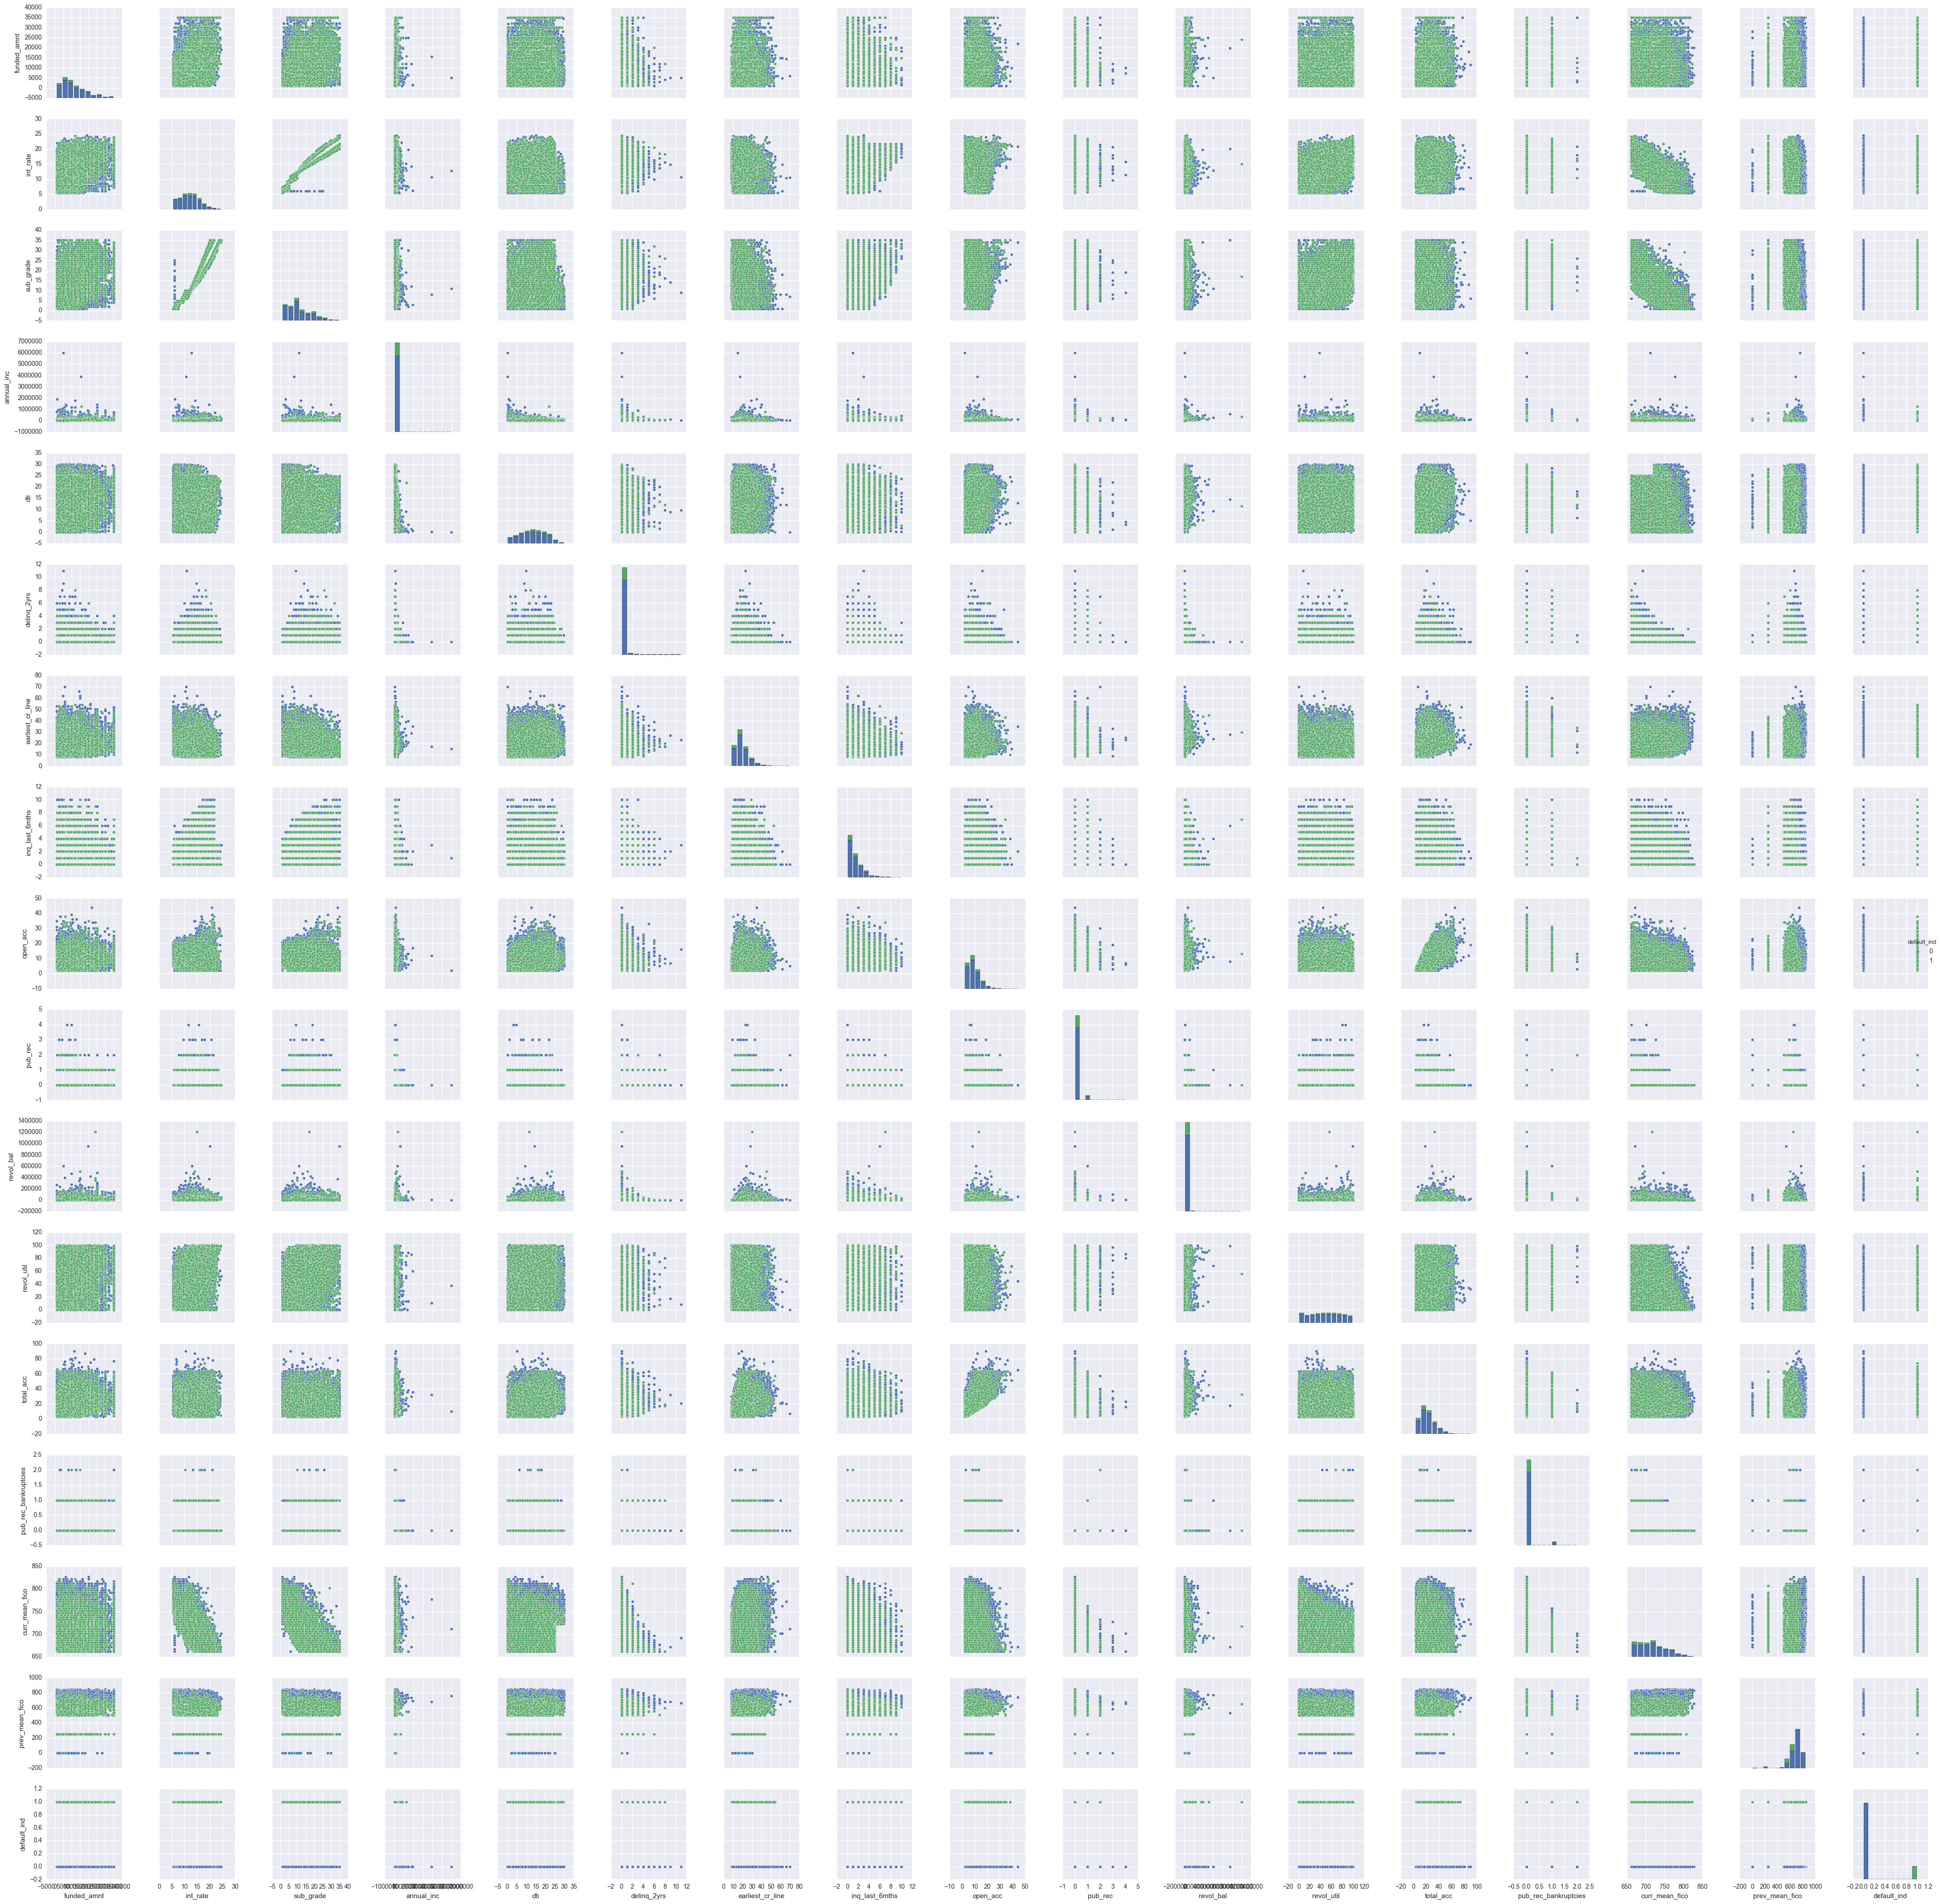

In [5]:
# Identifying columns that are empty for all rows,  These can be dropped
empty_columns = [col for col in full_data.columns if full_data[col].count() == 0]

# Identifying columns that are more than 50% empty. Guessing/Imputing for more than 50% of rows spoils prediction
fifty_pct_null_cols = [col for col in full_data.columns if full_data[col].isnull().sum() *1.0/full_data[col].count() > 0.5]

# Creating a list if columns that have only one value for all rows. Such rows does not help predicting
single_val_columns = ['initial_list_status', 'application_type', 'tax_liens', 'policy_code', 'delinq_amnt', \
                      'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'acc_now_delinq']

# Creating a list of columns that are corerelatd to each other. These columns have more than 85% corrleation to columns retained
correlated_columns = ['funded_amnt_inv', 'loan_amnt', 'installment', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',\
                      'total_rec_prncp', ]

# Using judgement to drop these columns.  This section is needed for the case where columns are decided on profiling
# id: is unique row/loan id integer field and thus removing
# member_id: is unique number per cusomter and can be removed
# emp_title: This field has lot ov weird valies and the number od distinct values are more than "" and does not make sense encoding them
# title: This field has lot of values historically. Some of them also have dates creating a large set.
#        Latest file has limited values but same exact values exist in 'purpose' field.  Droping this field
# addr_state: Considering zipcode (removing xx) to add more features, but removing state code from analysis.
# zip_code: Removed temporarily. Need to add back when we are using additional external features
# last_credit_pull_d: THis field contains last credit data was pulled and we may not need this data
# last_pymnt_d: Deleting this field thinking it might not be important. Also 71 values to impute
# loan_status: Derived calssification class column using this field. Dropping this field
# fico_range_low, fico_range_high: Derived curr_mean_fico using these feilds and dropping
# last_fico_range_low, last_fico_range_high: Derived prev_mean_ficp using these fields and dropping
# out_prncp: Per definition 'Remaining outstanding principal for total amount funded'. removing this field
# total_rec_int: per definition 'Interest received to date'. This is the total intrest received which obviously grows wth loan duration. 
# recoveries: Per definition 'post charge off gross recovery'. These are post default events, so dropping them
# collection_recovery_fee: Per definition 'post charge off collection fee'. These are post default events, so dropping them
# issue_d: Experimenting this column by removing. This played major factor as top 4th important attribute, but 
#          I could not figure out how this is so important
# grade and sub-grade are co-related. removing grade and leaving sub grade as its a lower grain
# total_rec_late_fee: Removing this attribute because this feature is not known while investing and thus may not
#                     will not help in predicting if it gets defaulted before investing
# last_pymnt_d: This date contains last payment date and is not valid before investing
# last_pymnt_amnt: This is last payment amount and is not valid before investing
manual_drop_columns = ['id', 'member_id', 'emp_title', 'title', 'addr_state', 'zip_code', 'last_credit_pull_d', \
                       'loan_status', 'fico_range_low', 'fico_range_high', 'last_fico_range_low', 'last_fico_range_high', \
                       'out_prncp', 'total_rec_int', 'recoveries', 'collection_recovery_fee', 'issue_d', 'grade',\
                       'total_rec_late_fee', 'last_pymnt_d', 'last_pymnt_amnt']

print 'Dropping empty columns: ', empty_columns
print
print 'Dropping columns with more than 50% empty: ', fifty_pct_null_cols
print
print 'Dropping Single Value columns: ', single_val_columns
print
print 'Dropping Correlated columns: ', correlated_columns
print
print 'Manually dropping columns: ', manual_drop_columns
print

# Concatenating all columns to be dropped
all_drop = np.concatenate((empty_columns, fifty_pct_null_cols, manual_drop_columns, single_val_columns, correlated_columns), \
                              axis = 0)

# Calling the function to clean data
train_data = clean_and_impute(full_data, all_drop)

# Ploting pair-wise plot with hue effect of default indicator
plt.figure()
sns.pairplot(data=train_data, hue="default_ind")
plt.tight_layout() 
plt.savefig("seaborn_pair_plot.png", bbox_inches='tight')

# Creating Class variables
train_y = train_data[['default_ind']]
train_data.drop(['default_ind'] ,1, inplace=True)

print 'Final List of Features used are:'
print train_data.columns

#unq_count = pd.DataFrame([len(pd.unique(train_data[col].ravel())) for col in train_data.columns]).set_index(train_data.columns)
#summary_df = pd.DataFrame(pd.concat([train_data.count(),  train_data.isnull().sum(), unq_count,  train_data.mean(), train_data.std()], axis = 1))
#summary_df.columns = ['Count', 'NullCount', 'UniqueCount',  'Mean', 'Variance']
#display(summary_df.sort(['UniqueCount', 'Variance'], ascending=[1, 1]))
#print summary_df.shape

In [6]:
# Checking for correlation again after all column removal
cor = train_data.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.85) | (cor < -0.85)]

# Because we converted Grade and Sub_grade to integer values during cleanup and impute process, they started showing
# again with high correlation. Leaving these in dataset for now

sub_grade  int_rate    0.964598
dtype: float64

In [7]:
#Define a function to one-hot encode data using the type of columns
#INPUT: Dataframe
#       Columns with categorical values
#OUTPUT: Encoded dataset
#Main functionality: Convert all categorical columns to independent columns and
#                    Standardize all parameters
def encode(data, encode_cols):
    encoded_x = pd.DataFrame({})
    
    for col in data.columns:
        
        if (col in encode_cols[:]):
            encoded = pd.get_dummies(data[col])
            encoded_x = pd.concat([encoded_x, encoded], axis = 1)
        else:
            data[col] = data[col].astype(float)
            #data[col] = (data[col] - data[col].min())/(data[col].max() - data[col].min())
            encoded_x = pd.concat([encoded_x, data[[col]]], axis = 1)
    
    return encoded_x

In [8]:
# Defining columns to encode
encode_cols = ['emp_length', 'home_ownership', 'verification_status', 'term', 'pymnt_plan', 'purpose']

#ENcoding columns
train_x = encode(train_data, encode_cols)

print train_x.shape

#Standardize data
train_x_std = (train_x - train_x.mean())/train_x.std()

#Displaying summary of data elements
unq_count = pd.DataFrame([len(pd.unique(train_x_std[col].ravel())) for col in train_x_std.columns]).set_index(train_x_std.columns)
summary_df = pd.DataFrame(pd.concat([train_x_std.count(),  train_x_std.isnull().sum(), unq_count,  train_x_std.mean(), train_x_std.std()], axis = 1))
summary_df.columns = ['Count', 'NullCount', 'UniqueCount',  'Mean', 'Variance']
display(summary_df.sort(['UniqueCount'], ascending=[1]))
print summary_df.shape



(39539, 53)


Count  NullCount  UniqueCount          Mean  Variance
y                     39539          0            2  2.073960e-15       1.0
Verified              39539          0            2 -3.677534e-14       1.0
n                     39539          0            2  9.998453e-15       1.0
car                   39539          0            2  1.699614e-14       1.0
credit_card           39539          0            2 -2.123289e-15       1.0
debt_consolidation    39539          0            2 -1.230144e-15       1.0
educational           39539          0            2 -4.748537e-14       1.0
home_improvement      39539          0            2  1.621742e-15       1.0
Source Verified       39539          0            2 -4.771449e-14       1.0
house                 39539          0            2  2.061238e-15       1.0
medical               39539          0            2  6.284108e-16       1.0
moving                39539          0            2  2.203592e-15       1.0
other                 39539          0            2  3.801330e-15       1.0
renewable_energy      39539          0            2  3.161614e-15       1.0
small_business        39539          0            2 -2.685022e-15       1.0
vacation              39539          0            2 -6.722643e-15       1.0
wedding               39539          0            2 -2.561541e-15       1.0
major_purchase        39539          0            2  7.864875e-15       1.0
RENT                  39539          0            2 -6.719990e-15       1.0
Not Verified          39539          0            2  2.239020e-14       1.0
OTHER                 39539          0            2  2.429717e-14       1.0
 36 months            39539          0            2 -5.708738e-14       1.0
 60 months            39539          0            2  5.708738e-14       1.0
1 year                39539          0            2 -3.729927e-16       1.0
10+ years             39539          0            2  3.004473e-14       1.0
2 years               39539          0            2  1.891058e-14       1.0
3 years               39539          0            2 -3.165589e-15       1.0
OWN                   39539          0            2  4.904805e-15       1.0
5 years               39539          0            2 -8.640121e-16       1.0
6 years               39539          0            2 -2.109783e-14       1.0
4 years               39539          0            2  1.320620e-15       1.0
8 years               39539          0            2  8.924549e-17       1.0
9 years               39539          0            2 -1.992248e-15       1.0
< 1 year              39539          0            2  6.008438e-15       1.0
n/a                   39539          0            2 -1.532200e-14       1.0
MORTGAGE              39539          0            2 -1.566447e-14       1.0
7 years               39539          0            2 -7.038429e-15       1.0
pub_rec_bankruptcies  39539          0            3  6.098119e-15       1.0
pub_rec               39539          0            5 -1.163438e-14       1.0
delinq_2yrs           39539          0           11 -1.988869e-15       1.0
inq_last_6mths        39539          0           11 -4.176620e-14       1.0
curr_mean_fico        39539          0           34 -9.196608e-16       1.0
sub_grade             39539          0           35  2.283254e-15       1.0
open_acc              39539          0           38 -2.674683e-16       1.0
earliest_cr_line      39539          0           53  5.082754e-16       1.0
prev_mean_fico        39539          0           72  3.744086e-16       1.0
total_acc             39539          0           81 -2.778189e-15       1.0
int_rate              39539          0          261  3.879806e-13       1.0
funded_amnt           39539          0         1031 -1.331189e-15       1.0
revol_util            39539          0         1096  1.799870e-15       1.0
dti                   39539          0         2867 -1.370370e-15       1.0
annual_inc            39539          0         5292 -1.341332e-15     

(53, 5)


In [9]:
# Converting to Numpy arrays to start modeling
y = train_y.default_ind.values.ravel()
X=train_x_std.values

print X.shape
print y.shape

(39539L, 53L)
(39539L,)


In [10]:
# Checking distribution of data
labels, label_counts = np.unique(y, return_counts=True)

print 'Class lables {}:{} are distributed in the counts {}:{}'.format(labels[0], labels[1], label_counts[0], label_counts[1])
print 'Class lables {}:{} are distributed in the ratio {}:1'.format(labels[0], labels[1], label_counts[0]/label_counts[1])

Class lables 0:1 are distributed in the counts 33776:5763
Class lables 0:1 are distributed in the ratio 5:1


Cumulative Variance explained for 45 components 0.996607892635


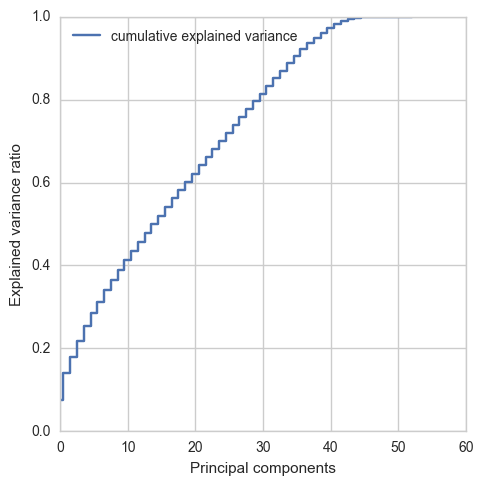

In [11]:
#Checking to see if we can reduce the columns further using PCA.
pca = PCA()
pca.fit(X)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print 'Cumulative Variance explained for 45 components', cum_var_exp[44]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    plt.step(range(X.shape[1]), cum_var_exp, where='mid',\
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig("PCA.png", bbox_inches='tight')
    
#After running PCA, we need atleast 45 components out of 53 attributes to get 99% accuracy. using PCA does not make sense.

In [12]:
# A generic function to do CV
# This function has been built on one of the examples given in class (Lecture 17)
def cv_optimize(clf, parameters, X, y, n_jobs=7, n_folds=10, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    return best

In [13]:
# Define a function that predicts classes for a given model. It also has provision for Gridsearch and Cross validation
# This function has been built on one of the examples given in class (Lecture 17)
# INPUT: A classifier
#        Input Dataset
#        List of features (predictors)
#        Name of field that contains different classes to predict
#        Value of class trying to predict
#        mask containing indexes to seperate train and test datasets
#        Re use split indicator
#        Scoring function to optimize
#        Number of times to cross fold (defaulted to 10)
#        number of parallel process to create(defaulted to 7 based on our system capability)
#        classifier name for printing purposes
# OUTPUTS: Best classifier based on scoring fuction
#          Measures - a combination of Precision, Recall/Sensitivity, Specificity, Accuracy, F1 Score
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, 
                score_func=None, n_folds=10, n_jobs=7, cls_nm = None):
    
    # Splitting dataset
    subdf=indf[featurenames]
    X=subdf.values
    
    #creating class set
    y=(indf[targetname].values==target1val)*1
    
    # Splitting data set to test train based on mask value
    if mask !=None:
        #print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    
    # Reuse existing split values
    if reuse_split !=None:
        #print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    
    #If hyper parameters are given call Gridsearch with Cross valudation to find best possible classifier
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    
    # Determine probability for each row using best hyper parameters
    yscore = clf.predict_proba(Xtest)
        
    #Create Plot to add ROC Curve and PR Curve
    fig, ax = plt.subplots(1, 2)
    plt.suptitle(cls_nm)
    
    # Fetch true positive rates and false positive rates for each of the thresholds
    fpr, tpr, threshold = metrics.roc_curve(ytest, yscore[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    ax[0].plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC Curve (AUC = %0.2f)' % roc_auc)
    ax[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC Curve')
    ax[0].legend(loc="lower right")

    # Fetch precesion and recall for each of the thresholds
    precision, recall, thresholds = metrics.precision_recall_curve(ytest, yscore[:,1])
    average_precision = metrics.average_precision_score(ytest, yscore[:,1])
    lw = 2
    ax[1].plot(recall, precision, color='darkorange',
         lw=lw, label='Precision-Recall Curve (AUC = %0.2f)' % average_precision)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    ax[1].legend(loc="lower right")
    
    plt.tight_layout() 
    plt.savefig(cls_nm + "_performance.png", bbox_inches='tight')
    plt.show()

    
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    
    # Create confusion matrix to determine true positives etc
    conf_matrix = confusion_matrix(ytest, clf.predict(Xtest))
    
    TP = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TN = conf_matrix[1][1]
    N = TP + FP + FN + TN
    
    # Calulating measures using best possible hyper-parameters
    PREC = TP*1.0/(TP+FP)
    RECALL = TP*1.0/(TP+FN)
    SPEC = TN*1.0/(TN+FP)
    ACC = (TN+TP)*1.0/N
    F1 = 2.0 * PREC * RECALL / (PREC + RECALL)
    
#    print "############# using ", cls_nm, " ################"
#    print 'Precesion         : ', PREC
#    print 'Recall/Sensitivity: ', RECALL
#    print 'Specificity       : ', SPEC
#    print 'Accuracy          : ', ACC
#    print 'F1 Score          : ', F1

#    print "Accuracy on training data: %0.2f" % (training_accuracy)
#    print "Accuracy on test data:     %0.2f" % (test_accuracy)
#    print confusion_matrix(ytest, clf.predict(Xtest))
#    print "#################################################"
    
    measures = [PREC, RECALL, SPEC, ACC, F1]
    return clf, measures

In [14]:
# Defining a function to plot feature importance for trees
# INPUT: TreeClassifier
#        Feature Names
# OUTPUT: A plot of top most features

def plot_feature_importance(model, Xnames, cls_nm = None):

    # Measuring important features
    imp_features = pd.DataFrame(np.column_stack((Xnames, model.feature_importances_)), columns = ['feature', 'importance'])
    imp_features[['importance']] = imp_features[['importance']].astype(float)
    # Considering only high importance features
    imp_features = imp_features[imp_features['importance'] > 0.002]
    imp_features = imp_features.sort_values(by = ['importance'], ascending = [1])
    
    # Print the feature ranking
    #print("Feature ranking:")
    #display(HTML(imp_features.to_html(index=False)))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title(cls_nm + " - Feature Importance")
    plt.barh(range(imp_features.shape[0]), imp_features['importance'],
            color="b", align="center")
    plt.yticks(range(imp_features.shape[0]), imp_features['feature'], )
    plt.ylim([-1, imp_features.shape[0]])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout() 
    plt.savefig(cls_nm + "_feature_imp.png", bbox_inches='tight')
    plt.show()

In [15]:
# Defining a function to plot coefficients as feature importance
# INPUT: Classifier
#        Feature Names
# OUTPUT: A plot of top most Coefficients
def plot_feature_importance_coeff(model, Xnames, cls_nm = None):

    imp_features = pd.DataFrame(np.column_stack((Xnames, model.coef_.ravel())), columns = ['feature', 'importance'])
    imp_features[['importance']] = imp_features[['importance']].astype(float)
    imp_features = imp_features[imp_features['importance'] > 0.002]
    imp_features = imp_features.sort_values(by = ['importance'], ascending = [1])
    
    # Print the feature ranking
    #print("Feature ranking:")
    #display(HTML(imp_features.to_html(index=False)))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title(cls_nm + " - Feature Importance")
    plt.barh(range(imp_features.shape[0]), imp_features['importance'],
            color="b", align="center")
    plt.yticks(range(imp_features.shape[0]), imp_features['feature'], )
    plt.ylim([-1, imp_features.shape[0]])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout() 
    plt.savefig(cls_nm + "_feature_imp.png", bbox_inches='tight')
    plt.show()

In [16]:
# Defining a dataframe to capture results so they can be compared
columns = ['Precision', 'Recall', 'Specificity', 'Accuracy', 'F1 Score', 'Execution Cost']
measures_df = pd.DataFrame(columns=columns)
all_classifiers = []

In [17]:
# Combining features and classes
final_df=pd.concat([train_x_std, train_y], axis=1)
Xnames = list(train_x_std.columns.values)

#Explaining features to make feature importance graph more readable
Xnames_detail= ['Loan Amount', '30 mo. Loan', '60 mo. Loan', 'Interest Rate', 'Loan Sub Grade', '1 Yr. Job Experience', '10+ Yr. Job Experience', '2 Yr. Job Experience', \
 '3 Yr. Job Experience', '4 Yr. Job Experience', '5 Yr. Job Experience', '6 Yr. Job Experience', '7 Yr. Job Experience', '8 Yr. Job Experience', '9 Yr. Job Experience', \
 '<1 Yr. Job Experience', 'Unknown Home Ownership', 'Mortage', 'Other Home Ownership', 'Own Home', 'Rent Home', 'Annual Income', \
 'Income Not Verified', 'Income Source Verified', 'Verified', 'Payment Plan', 'No Payment Plan', 'Loan for Car', 'Loan for Credit Card', \
 'Loan for debt Consolidation', 'Loan for Education', 'Loan for Home Improvement', 'Loan for House', 'Loan for Major Purchase', 'Loan for Medical', \
 'Loan for Moving', 'Loan for Other', 'Loan for Renewable Energy', 'Loan for Small Business', 'Loan for Vacation', 'Loan for Wedding', 'Debt to Income Ratio', \
 'Deliquencies in last 2 Yr.', 'Credit History Length', 'Inquires in last 6 mo.', 'No. of Open Credit Lines', 'No. of Derogatory Public Records', \
 'Revolving Balance', 'Revolving Utilization', 'No. of Credit Lines', 'No. of Bankruptcies', 'Current FICO Score', 'Previous FICO Score']

print "Mean of dataset:", np.mean(final_df['default_ind'])

# Create test/train mask
itrain, itest = train_test_split(xrange(final_df.shape[0]), train_size=0.6)
mask=np.ones(final_df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
#Below command converts binary to boolean (1->True, 0->False)
mask = (mask==1)

# make sure we didn't get unlucky in our mask selection
print "% Default Loans in Training:", np.mean(final_df.default_ind[mask]), np.std((final_df.default_ind[mask]))
print "% Default Loans in Testing:", np.mean(final_df.default_ind[~mask]), np.std((final_df.default_ind[~mask]))

Mean of dataset: 0.145754824351
% Default Loans in Training: 0.146187244446 0.353331804276
% Default Loans in Testing: 0.145106221548 0.352170705795


**Analysis**

We are looking at the case where the proportion of defaulted loans in very imbalanced in the data.  There are only a few loans that are in default (which should be the case to run the business), compared to non-defaulted data

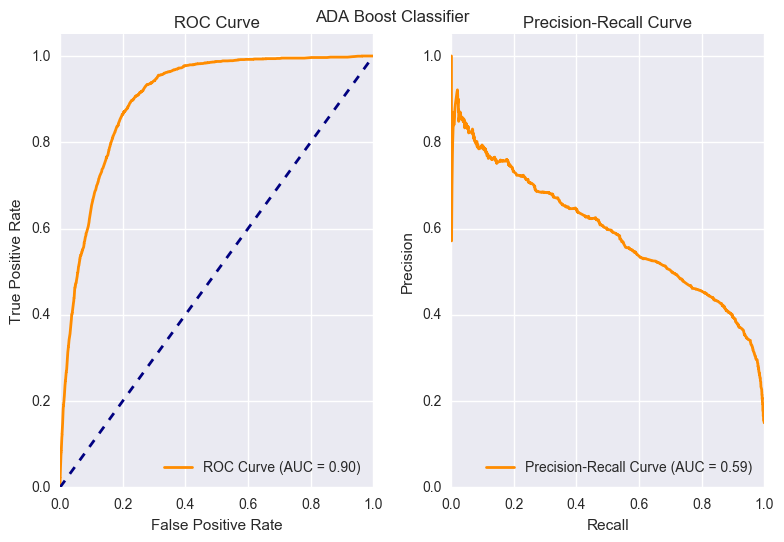

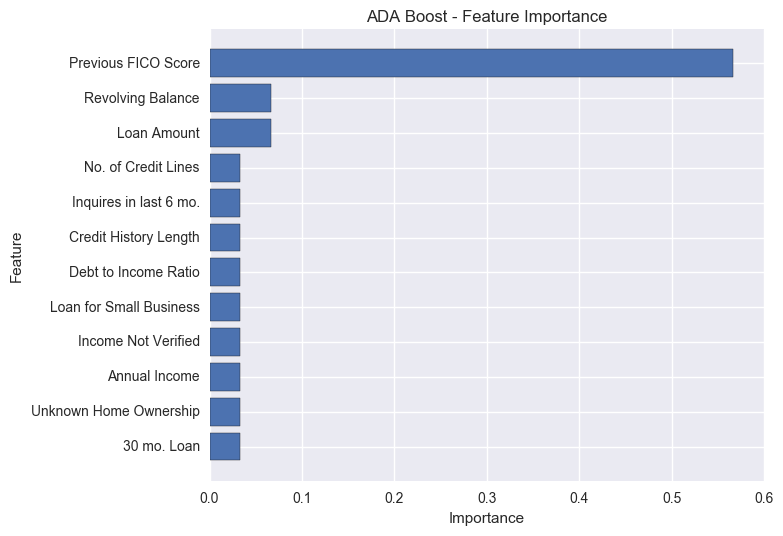

Precision    Recall  Specificity  Accuracy  F1 Score Execution Cost
ADA_Boost    0.95311  0.912419     0.625296  0.881702   0.93232      0.387 min

In [18]:
#ADA Boost Classifier

#Tuning Parameters
tot_estimators = [2, 10, 30, 50, 70, 90]
parameters = {'n_estimators': tot_estimators}
#Initiating Classifier
cls = AdaBoostClassifier()

#Starting Gridsearch CV
start = time.clock()
ada_best, ada_measures = do_classify(cls, parameters, final_df, Xnames, 'default_ind', 1, 
                                                        mask=mask, score_func = 'roc_auc', cls_nm = 'ADA Boost Classifier')
all_classifiers.append(ada_best)
np.save('all_models_reg_n_grade.npy', all_classifiers)

end = time.clock()

#Adding execution time as a measure to compare
ada_measures.append(str(round((end - start)*1.0/60, 3)) + ' min')

measures_df.ix['ADA_Boost'] = ada_measures

#Plot feature importance graph
plot_feature_importance(ada_best, Xnames_detail, cls_nm = 'ADA Boost')
display(measures_df)

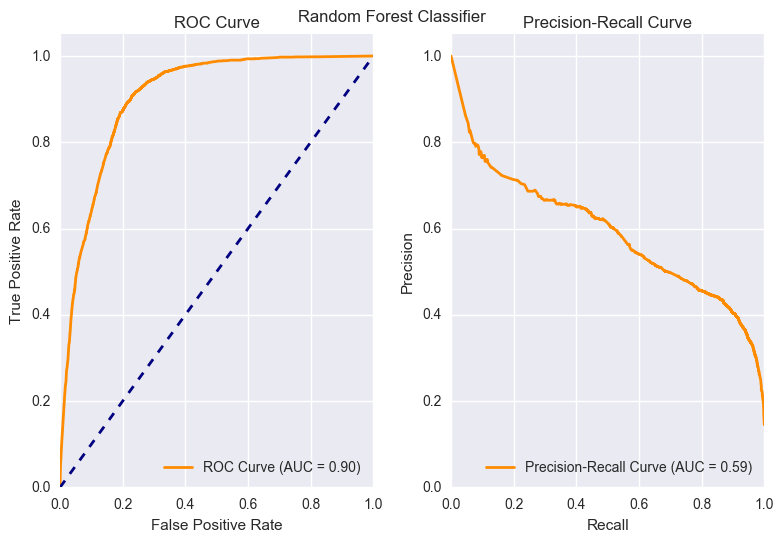

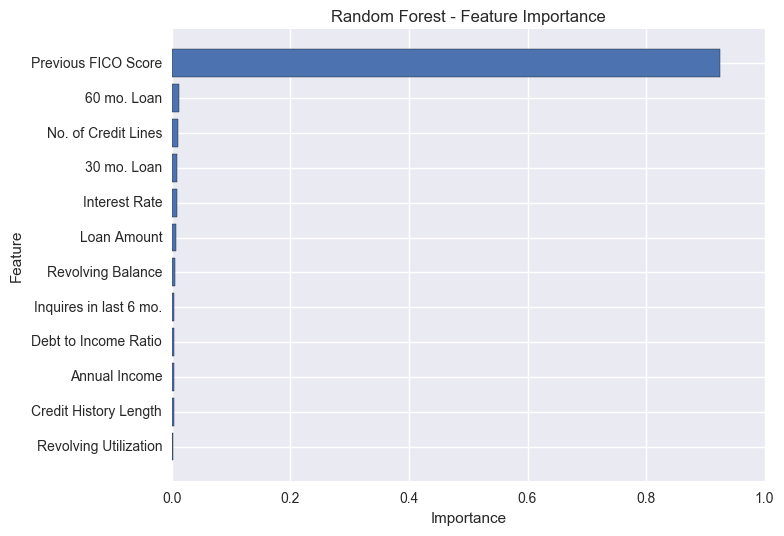

Precision    Recall  Specificity  Accuracy  F1 Score  \
ADA_Boost       0.953110  0.912419     0.625296  0.881702   0.93232   
RandomForests   0.785297  0.976997     0.413298  0.800645   0.87072   

              Execution Cost  
ADA_Boost          0.387 min  
RandomForests     12.356 min

In [19]:
#Random Forest Classifier

#Tuning Parameters
tot_estimators = [2, 5, 10, 15, 20]
tot_features = [2, 5, 7, 8, 10, 20, 30 ,40 ,50, 53]
tot_max_depth = [5, 10, 15, 20]
tot_min_samp_leaf = [1, 2, 5]
parameters = {'n_estimators': tot_estimators, 'max_features': tot_features, 'max_depth': tot_max_depth,\
              'min_samples_leaf': tot_min_samp_leaf}

#Initiating Classifier
cls = RandomForest(oob_score=True, class_weight='balanced')

#Starting Gridsearch CV
start = time.clock()
randforest_best, randforest_measures = do_classify(cls, parameters, final_df, Xnames, 'default_ind', 1, 
                                                        mask=mask, score_func = 'roc_auc', cls_nm = 'Random Forest Classifier')
all_classifiers.append(randforest_best)
np.save('all_models_reg_n_grade.npy', all_classifiers)

end = time.clock()

#Adding execution time as a measure to compare
randforest_measures.append(str(round((end - start)*1.0/60, 3)) + ' min')

measures_df.ix['RandomForests'] = randforest_measures

#Plot feature importance graph
plot_feature_importance(randforest_best, Xnames_detail, cls_nm = 'Random Forest')
display(measures_df)

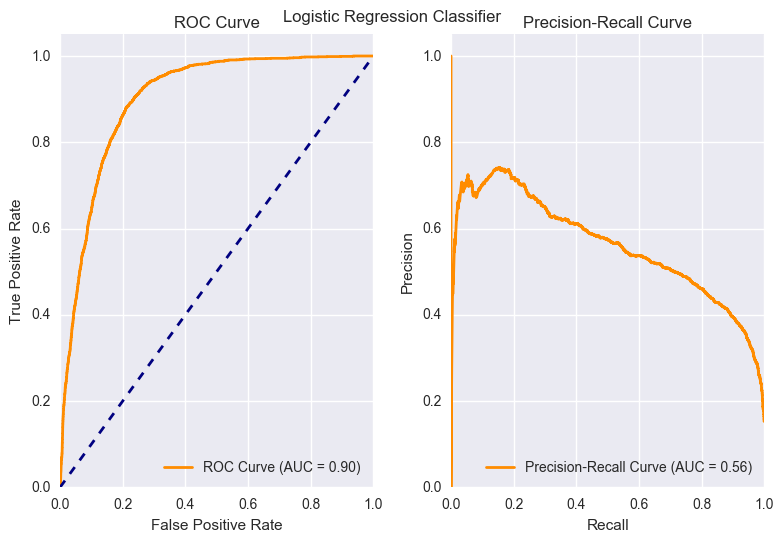

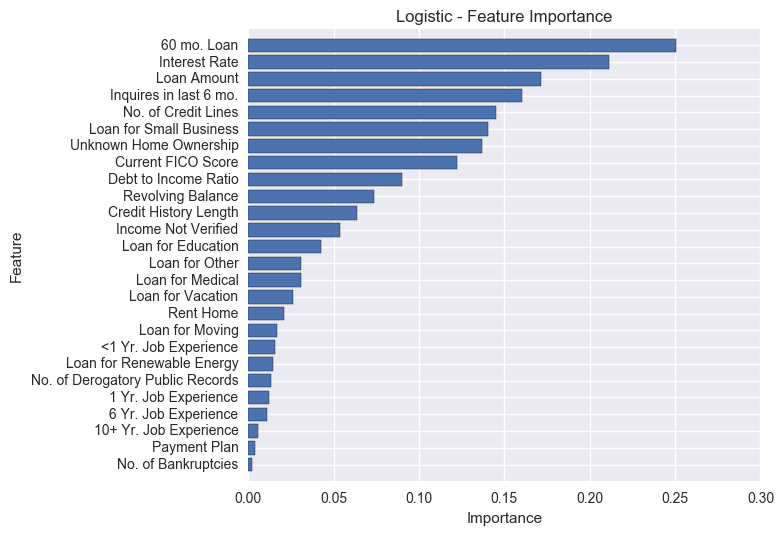

Precision    Recall  Specificity  Accuracy  F1 Score  \
ADA_Boost       0.953110  0.912419     0.625296  0.881702  0.932320   
RandomForests   0.785297  0.976997     0.413298  0.800645  0.870720   
Logistic        0.827084  0.964218     0.445709  0.825936  0.890402   

              Execution Cost  
ADA_Boost          0.387 min  
RandomForests     12.356 min  
Logistic           0.265 min

In [20]:
#Logistic Regression Classifier with different C

#Tuning Parameters
parameters = {"C": [1e-7, 1e-3, 1e0, 1e3, 1e7], "penalty": ['l1','l2']}

#Initiating Classifier
cls = LogisticRegression(class_weight='balanced')

#Starting Gridsearch CV
start = time.clock()
logreg_best, logreg_measures = do_classify(cls, parameters, final_df, Xnames, 'default_ind', 1, 
                                                        mask=mask, score_func = 'roc_auc', cls_nm = 'Logistic Regression Classifier')

all_classifiers.append(logreg_best)
np.save('all_models_reg_n_grade.npy', all_classifiers)

end = time.clock()

#Adding execution time as a measure to compare
logreg_measures.append(str(round((end - start)*1.0/60, 3)) + ' min')

measures_df.ix['Logistic'] = logreg_measures

#Plot feature importance graph
plot_feature_importance_coeff(logreg_best, Xnames_detail, cls_nm = 'Logistic')
display(measures_df)

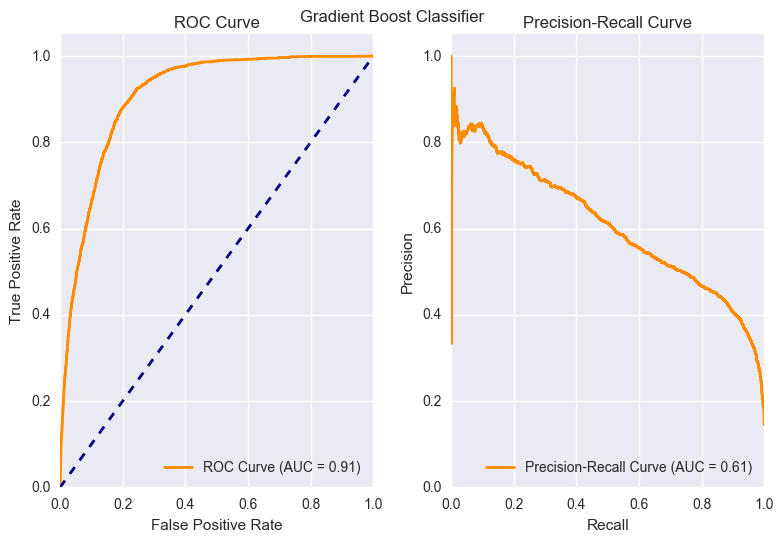

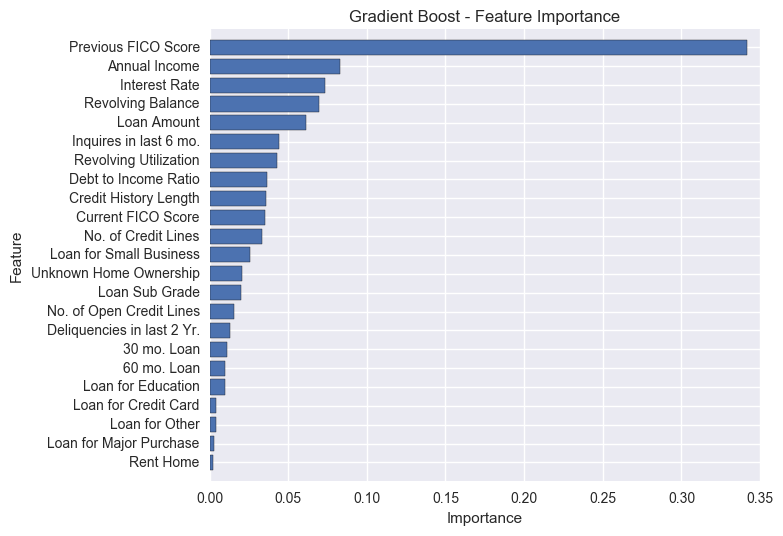

Precision    Recall  Specificity  Accuracy  F1 Score  \
ADA_Boost       0.953110  0.912419     0.625296  0.881702  0.932320   
RandomForests   0.785297  0.976997     0.413298  0.800645  0.870720   
Logistic        0.827084  0.964218     0.445709  0.825936  0.890402   
GradientBoost   0.957104  0.911017     0.639975  0.883409  0.933492   

              Execution Cost  
ADA_Boost          0.387 min  
RandomForests     12.356 min  
Logistic           0.265 min  
GradientBoost    149.245 min

In [21]:
#Gradient Boosting Classifier

#Tuning Parameters
tot_estimators = [25, 50, 100, 150, 200]
tot_max_depth = [2, 3, 5, 10]
tot_min_samp_leaf = [1, 2, 5]
tot_features = [2, 5, 7, 8, 10, 30, 50, 53]
parameters = {'n_estimators': tot_estimators, 'max_features': tot_features, 'max_depth': tot_max_depth,\
              'min_samples_leaf': tot_min_samp_leaf}

#Initiating Classifier
cls = GradientBoostingClassifier()

#Starting Gridsearch CV
start = time.clock()
gradient_best, gradient_measures = do_classify(cls, parameters, final_df, Xnames, 'default_ind', 1, 
                                                        mask=mask, score_func = 'roc_auc', cls_nm = 'Gradient Boost Classifier')

all_classifiers.append(gradient_best)
np.save('all_models_reg_n_grade.npy', all_classifiers)

end = time.clock()

#Adding execution time as a measure to compare
gradient_measures.append(str(round((end - start)*1.0/60, 3)) + ' min')

measures_df.ix['GradientBoost'] = gradient_measures

#Plot feature importance graph
plot_feature_importance(gradient_best, Xnames_detail, cls_nm = 'Gradient Boost')
display(measures_df)

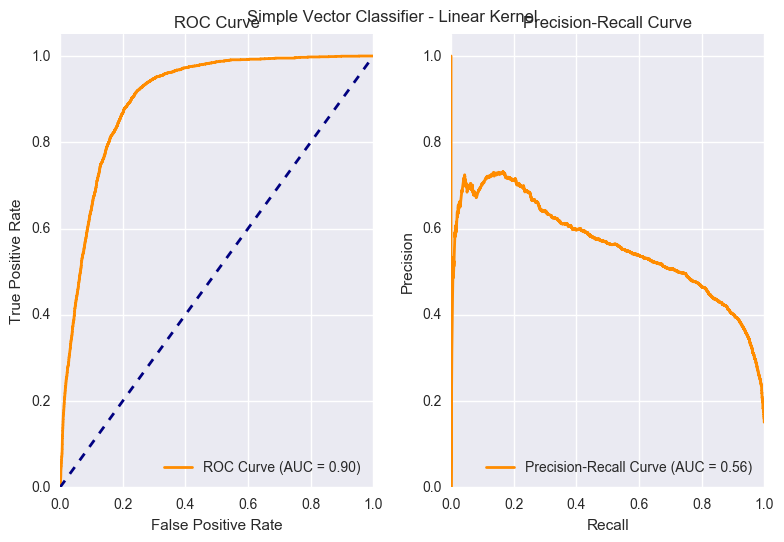

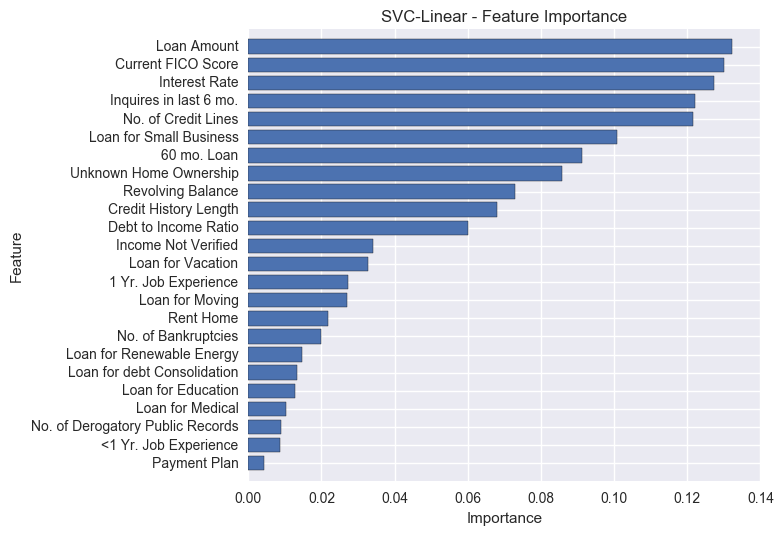

Precision    Recall  Specificity  Accuracy  F1 Score  \
ADA_Boost       0.953110  0.912419     0.625296  0.881702  0.932320   
RandomForests   0.785297  0.976997     0.413298  0.800645  0.870720   
Logistic        0.827084  0.964218     0.445709  0.825936  0.890402   
GradientBoost   0.957104  0.911017     0.639975  0.883409  0.933492   
SVM Linear      0.814289  0.968679     0.435730  0.818728  0.884799   

              Execution Cost  
ADA_Boost          0.387 min  
RandomForests     12.356 min  
Logistic           0.265 min  
GradientBoost    149.245 min  
SVM Linear       587.923 min

In [22]:
#SVM with Linear Kernel

#Tuning Parameters
parameters = {'C':[0.1,1, 10, 100]}

#Initiating Classifier
cls = svm.SVC(kernel='linear', class_weight='balanced', probability=True)

#Starting Gridsearch CV
start = time.clock()
svm_lin_best, svm_lin_measures = do_classify(cls, parameters, final_df, Xnames, 'default_ind', 1, 
                                                        mask=mask, score_func = 'roc_auc', cls_nm = 'Simple Vector Classifier - Linear Kernel')

all_classifiers.append(svm_lin_best)
np.save('all_models_reg_n_grade.npy', all_classifiers)

end = time.clock()

#Adding execution time as a measure to compare
svm_lin_measures.append(str(round((end - start)*1.0/60, 3)) + ' min')

measures_df.ix['SVM Linear'] = svm_lin_measures

#Plot feature importance graph
plot_feature_importance_coeff(svm_lin_best, Xnames_detail, cls_nm = 'SVC-Linear')
display(measures_df)

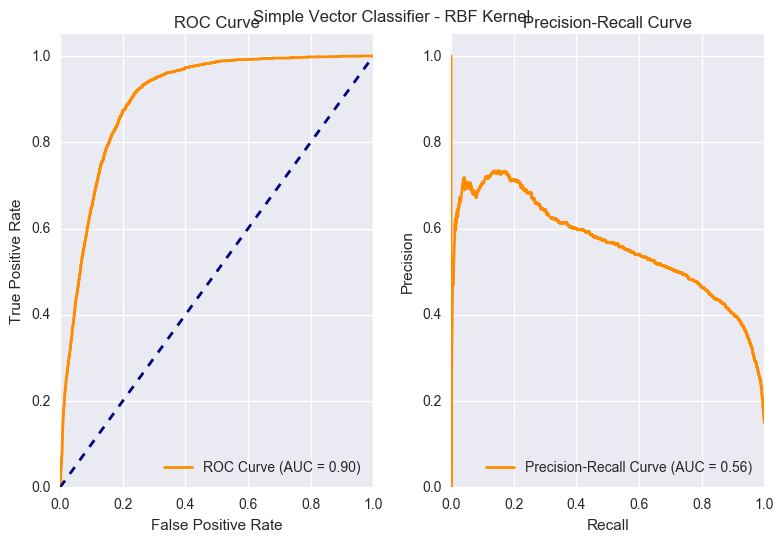

Precision    Recall  Specificity  Accuracy  F1 Score  \
ADA_Boost       0.953110  0.912419     0.625296  0.881702  0.932320   
RandomForests   0.785297  0.976997     0.413298  0.800645  0.870720   
Logistic        0.827084  0.964218     0.445709  0.825936  0.890402   
GradientBoost   0.957104  0.911017     0.639975  0.883409  0.933492   
SVM Linear      0.814289  0.968679     0.435730  0.818728  0.884799   
SVM RBF         0.815472  0.968382     0.436795  0.819487  0.885374   

              Execution Cost  
ADA_Boost          0.387 min  
RandomForests     12.356 min  
Logistic           0.265 min  
GradientBoost    149.245 min  
SVM Linear       587.923 min  
SVM RBF            85.51 min

In [23]:
# SVM with RBF Kernel

#Tuning Parameters
parameters = {'C':[0.1, 1, 10, 100], 'gamma': [0.001, 0.0001]}

#Initiating Classifier
cls = svm.SVC(kernel='rbf', class_weight='balanced', probability=True)

#Starting Gridsearch CV
start = time.clock()
svm_rbf_best, svm_rbf_measures = do_classify(cls, parameters, final_df, Xnames, 'default_ind', 1, 
                                                        mask=mask, score_func = 'roc_auc', cls_nm = 'Simple Vector Classifier - RBF Kernel')

all_classifiers.append(svm_rbf_best)
np.save('all_models_reg_n_grade.npy', all_classifiers)

end = time.clock()

#Adding execution time as a measure to compare
svm_rbf_measures.append(str(round((end - start)*1.0/60, 3)) + ' min')

measures_df.ix['SVM RBF'] = svm_rbf_measures
display(measures_df)

In [24]:
print 'Below are the best hyper-parameters after tuning each model:'
print
for md in range(len(all_classifiers)):
    print all_classifiers[md]
    print 

Below are the best hyper-parameters after tuning each model:

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=30, random_state=None)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=50,
            max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=50, max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
 

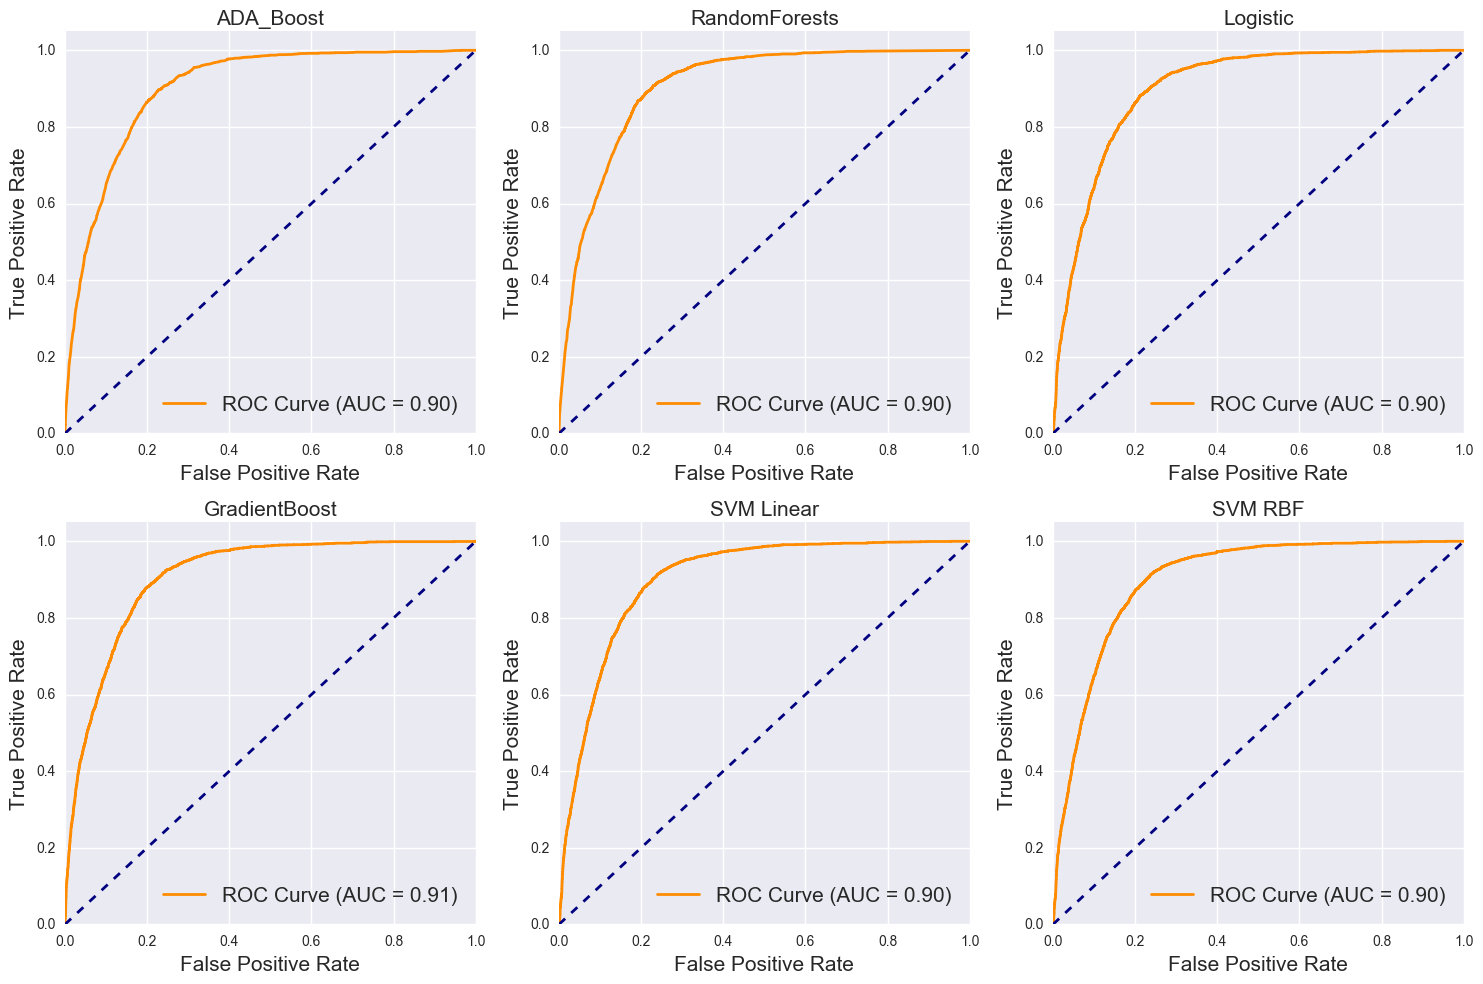

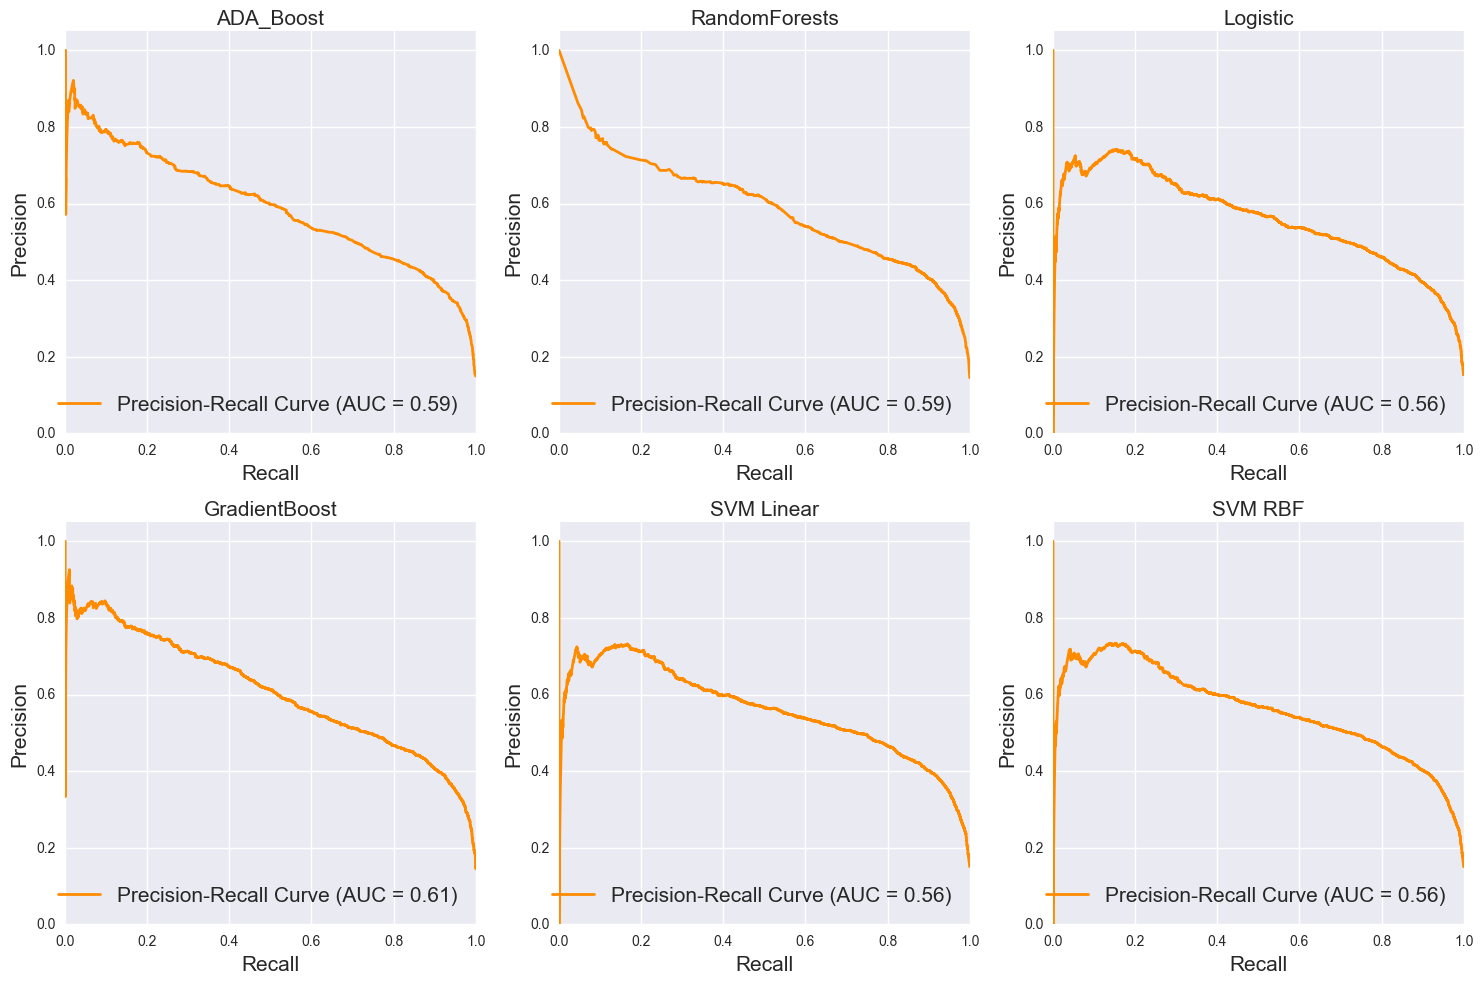

In [25]:
def plot_roc_curve(ytest, yscore, ax, color, cat):
    
    fpr, tpr, threshold = metrics.roc_curve(ytest, yscore)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    ax.plot(fpr, tpr, color=color,
         lw=lw, label='ROC Curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize = 15)
    ax.set_ylabel('True Positive Rate', fontsize = 15)
    ax.set_title(cat, fontsize = 15)
    ax.legend(loc="lower right", fontsize = 15)


def plot_pr_curve(ytest, yscore, ax, color, cat):
    
    precision, recall, thresholds = metrics.precision_recall_curve(ytest, yscore)
    average_precision = metrics.average_precision_score(ytest, yscore)
    lw = 2
    ax.plot(recall, precision, color=color,
         lw=lw, label='Precision-Recall Curve (AUC = %0.2f)' % average_precision)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize = 15)
    ax.set_ylabel('Precision', fontsize = 15)
    ax.set_title(cat, fontsize = 15)
    ax.legend(loc="lower right", fontsize = 15)

    

    
    
X=final_df[Xnames].values
y=final_df['default_ind'].values

X_test, y_test = X[~mask], y[~mask]

fig1, roc = plt.subplots(2, 3, figsize=(15, 10))
#plt.suptitle('ROC Curve', fontsize = 20)

fig2, pr = plt.subplots(2, 3, figsize=(15, 10))
#plt.suptitle('Precision-Recall Curve', fontsize = 20)

model_names = measures_df.index
plot_colors = ['darkorange', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'darkorange']
i=0
j=0
for m in range(len(all_classifiers)):
    y_score = all_classifiers[m].predict_proba(X_test)[:, 1]
    plot_roc_curve(y_test, y_score, roc[i][j], plot_colors[m], model_names[m])
    plot_pr_curve(y_test, y_score, pr[i][j], plot_colors[m], model_names[m])
    
    if j == 2:
        j = 0
        i += 1
    else:
        j += 1
    
fig1.tight_layout()
fig2.tight_layout()
plt.tight_layout() 
plt.savefig("ROC_PR.png", bbox_inches='tight')
plt.show()

In [1]:
# Grabbed parts of this code from web at last moment. Could not save web link

from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_confusion_matrix(C,class_labels=['0','1'],
                          title='Confusion Matrix for Best Classifier',):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """ 
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    im = ax.imshow(C, interpolation='nearest', cmap=plt.cm.Blues)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('Actual', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'Specificity: %.4f'%(tn / (tn+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'Recall: %.4f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.4f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'F1 Score: %.4f'%((2.0*(tp/(tp+fp+0.))*(tp / (tp+fn+0.)))/((tp/(tp+fp+0.))+(tp / (tp+fn+0.)))),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Precision: %.4f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.savefig("Confusion_Matrix.png", bbox_inches='tight')
    plt.show()

In [30]:
# Grabbed parts of this code from web at last moment. Could not save web link

import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix for Best Classifier',
                          cmap=plt.cm.Blues):
    plt.figure()
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    #print("Confusion Matrix for Best Classifier")
    #print(cm)
    
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] == cm.max() else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout() 
    plt.savefig("Confusion_Matrix_simple.png", bbox_inches='tight')
    plt.show()

Precision    Recall  Specificity  Accuracy  F1 Score  \
ADA_Boost       0.625296  0.461002     0.953110  0.881702  0.530725   
RandomForests   0.413298  0.891068     0.785297  0.800645  0.564683   
Logistic        0.445709  0.819172     0.827084  0.825936  0.577307   
GradientBoost   0.639975  0.449237     0.957104  0.883409  0.527906   
SVM Linear      0.435730  0.844880     0.814289  0.818728  0.574944   
SVM RBF         0.436795  0.843137     0.815472  0.819487  0.575465   

              Execution Cost  
ADA_Boost          0.387 min  
RandomForests     12.356 min  
Logistic           0.265 min  
GradientBoost    149.245 min  
SVM Linear       587.923 min  
SVM RBF            85.51 min

############# Best Model Measures ################
Precision         :  0.445708866761
Recall/Sensitivity:  0.81917211329
Specificity       :  0.827083795577
Accuracy          :  0.825935761254
F1 Score          :  0.577306924612
Confusion Matrix:


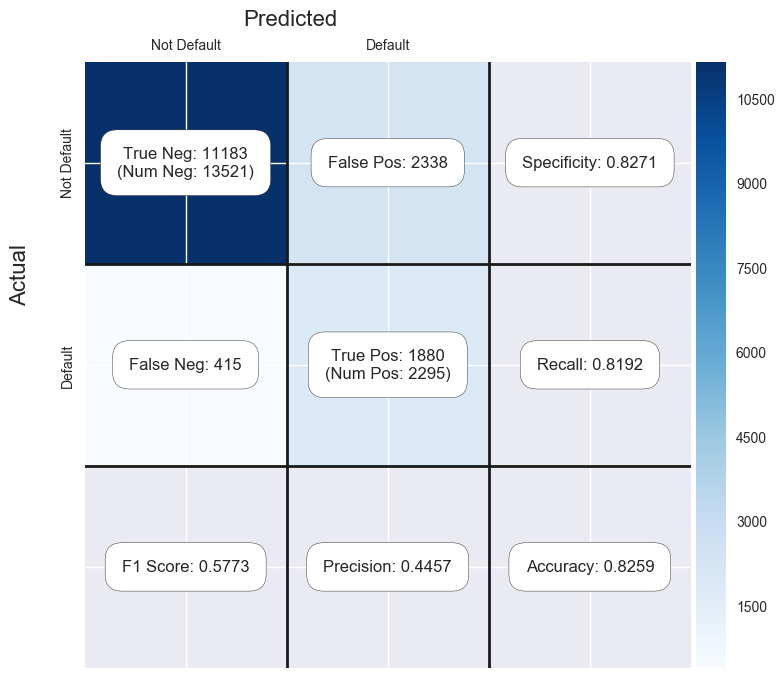

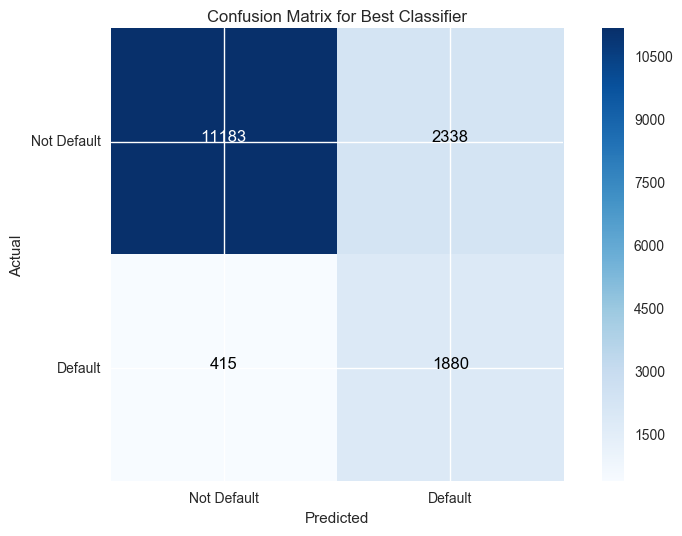

In [43]:
#We have realized that the formuale to calculate measures had an error and thus we re-generated the grid.  
# With limited time at hand, we did not fix the formulae in main function and run entire notebook again.
def collect_measures(all_model, Xtest, ytest, model_nm):
    
    columns = ['Precision', 'Recall', 'Specificity', 'Accuracy', 'F1 Score']
    final_measures_df = pd.DataFrame(columns=columns)
    
    mdl = 0
    for model in all_model:
        ypred = model.predict(Xtest)
        conf_matrix = confusion_matrix(ytest, ypred, labels)
        
        TN = conf_matrix[0][0]
        FP = conf_matrix[0][1]
        FN = conf_matrix[1][0]
        TP = conf_matrix[1][1]
        N = TP + FP + FN + TN

        PREC = TP*1.0/(TP+FP)
        RECALL = TP*1.0/(TP+FN)
        SPEC = TN*1.0/(TN+FP)
        ACC = (TN+TP)*1.0/N
        F1 = 2.0 * PREC * RECALL / (PREC + RECALL)
        
        final_measures_df.ix[model_nm[mdl]]= [PREC, RECALL, SPEC, ACC, F1]
        
        mdl += 1
        
    return final_measures_df
    
final_measures_df = collect_measures(all_classifiers, X_test, y_test, measures_df.index)
final_measures_df['Execution Cost'] = measures_df['Execution Cost'].values
display(final_measures_df)
        

def print_model_eval_measures(model, ytest, ypred):
    conf_matrix = confusion_matrix(ytest, ypred, labels)
    
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]
    N = TP + FP + FN + TN
    
    PREC = TP*1.0/(TP+FP)
    RECALL = TP*1.0/(TP+FN)
    SPEC = TN*1.0/(TN+FP)
    ACC = (TN+TP)*1.0/N
    F1 = 2.0 * PREC * RECALL / (PREC + RECALL)
    
    label = ['Not Default', 'Default']
        
    print "############# Best Model Measures ################"
    print 'Precision         : ', PREC
    print 'Recall/Sensitivity: ', RECALL
    print 'Specificity       : ', SPEC
    print 'Accuracy          : ', ACC
    print 'F1 Score          : ', F1    
    print 'Confusion Matrix:'
    
    show_confusion_matrix(conf_matrix, label)
    
    plot_confusion_matrix(conf_matrix, classes=label)

best_model = logreg_best
y_pred = best_model.predict(X_test)
print_model_eval_measures(best_model, y_test, y_pred)

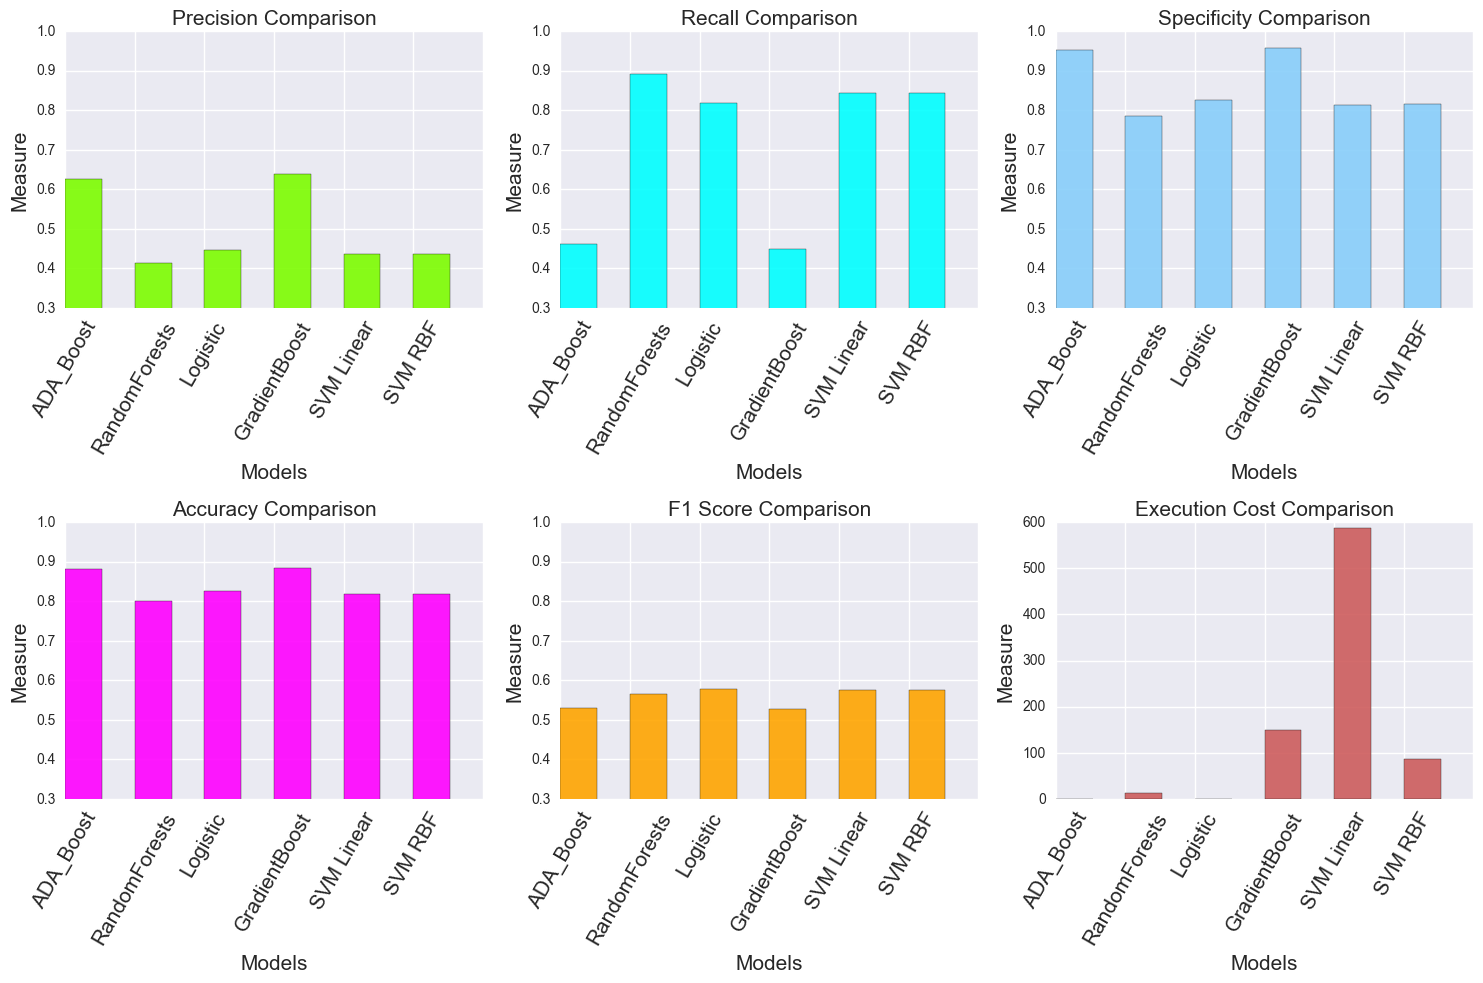

In [38]:
def plot_measures(results):
    models = results.index
    measures = results.columns
    
    plot_colors = ['lawngreen', 'aqua', 'lightskyblue', 'magenta', 'orange', 'indianred']
    
    fig, msr = plt.subplots(2, 3, figsize=(15, 10))
    
    i=0
    j=0
    for m in range(len(measures)):
        bar_vals = results[measures[m]].values
        bar_vals = [str(s).replace(' min' , '') for s in bar_vals]
        msr[i][j].bar(range(0,len(models)), bar_vals, color = plot_colors[m], width = 0.53, alpha=0.9 )
        msr[i][j].set_xticklabels(models, rotation=60, minor=False, fontsize = 15)
        msr[i][j].set_xlabel('Models', fontsize = 15)
        msr[i][j].set_ylabel('Measure', fontsize = 15)
        msr[i][j].set_title(measures[m] + ' Comparison', fontsize = 15)
        if j != 2:
            msr[i][j].set_ylim([0.3, 1.00])
        elif i == 0:
            msr[i][j].set_ylim([0.3, 1.00])
        
        if j == 2:
            j = 0
            i += 1
        else:
            j += 1
            
    fig.tight_layout()
    plt.savefig("Results_Comparition.png", bbox_inches='tight')
    plt.show()
    
    
    
plot_measures(final_measures_df)